In [1]:
%matplotlib inline

In [2]:
import math 
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import brentq
import pandas as pd
from matplotlib.gridspec import GridSpec

from tqdm.notebook import trange

In [3]:
plt.style.use('scientific')

In [4]:
from rsnn.spike_train.generator import PeriodicSpikeTrainGenerator, SpikeTrainGenerator
from rsnn.spike_train.spike_train import SpikeTrain
from rsnn.rsnn.neuron import Neuron
from rsnn.optim.gmp import observation_block_forward, equality_block
from rsnn.optim.nuv import binary_prior, box_prior, pnorm_prior, laplace_prior, half_space_prior, plain_prior
from rsnn.optim.cost import box_cost, half_space_cost, plain_cost, laplace_cost, pnorm_cost
from rsnn.spike_train.measure import single_channel_correlation
from rsnn.utils.utils import cyclic_after, cyclic_before, cyclic_neighborhood

/Users/haguettaz/Documents/RSNN/src/rsnn/spike_train/generator.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


In [5]:
rng = np.random.default_rng(42)

# Supervised Learning for Spiking Neurons

In [6]:
num_inputs = 250 # number of synapses
delays = rng.uniform(1.0, 20.0, num_inputs)
synapse_beta, soma_decay = 4, 5
firing_threshold = 1.0
wmin, wmax = -0.1, 0.1

period = 100.0
firing_rate, rel_refractory_period, abs_refractory_period = 0.1, 5.0, 5.0
refractory_weight = 1

In [7]:
times = np.linspace(0, period, 10000)

In [8]:
def input_spike_resp(t):
    tmax = (math.log(synapse_beta) - math.log(soma_decay)) / (1 / soma_decay - 1 / synapse_beta)
    gamma = 1 / (math.exp(-tmax / soma_decay) - math.exp(-tmax / synapse_beta))

    if isinstance(t, np.ndarray):
        z = gamma * (np.exp(-t / soma_decay) - np.exp(-t / synapse_beta))
        z[t < 0] = 0.0
        return z
    
    if t < 0:
        return 0.0
    
    return gamma * (np.exp(-t / soma_decay) - np.exp(-t / synapse_beta))

def input_spike_resp_deriv(t):
    tmax = (math.log(synapse_beta) - math.log(soma_decay)) / (1 / soma_decay - 1 / synapse_beta)
    gamma = 1 / (math.exp(-tmax / soma_decay) - math.exp(-tmax / synapse_beta))

    if isinstance(t, np.ndarray):
        z = gamma * (np.exp(-t / synapse_beta) / synapse_beta - np.exp(-t / soma_decay) / soma_decay)
        z[t < 0] = 0.0
        return z
    
    if t < 0:
        return 0.0
    
    return gamma * (np.exp(-t / synapse_beta) / synapse_beta - np.exp(-t / soma_decay) / soma_decay)

def refractory_spike_resp(t):
    if isinstance(t, np.ndarray):
        z = -refractory_weight * np.exp(- (t - abs_refractory_period) / soma_decay)
        z[t <= abs_refractory_period] = -np.inf
        z[t <= 0] = 0.0
        return z
    
    if t <= 0:
        return 0.0
    
    if t <= abs_refractory_period:
        return -np.inf
    
    return -refractory_weight * np.exp(- (t - abs_refractory_period) / soma_decay)

In [9]:
def potential(t, delays, weights, input_spike_trains, modulo=True):
    if isinstance(t, np.ndarray):
        if modulo:
            y = np.array([
                np.sum(input_spike_resp((t[None,:] - delays[k] - input_spike_trains.spike_trains[k].firing_times[:,None])%period), axis=0) for k in range(num_inputs)
            ])
            return weights@y
        
        y = np.array([
            np.sum(input_spike_resp((t[None,:] - delays[k] - input_spike_trains.spike_trains[k].firing_times[:,None])), axis=0) for k in range(num_inputs)
        ])
        return weights@y  
        
    if modulo:
        y = np.array([
            np.sum(input_spike_resp((t - delays[k] - input_spike_trains.spike_trains[k].firing_times)%period), axis=0) for k in range(num_inputs)
        ])
        return weights@y
    
    y = np.array([
        np.sum(input_spike_resp((t - delays[k] - input_spike_trains.spike_trains[k].firing_times)), axis=0) for k in range(num_inputs)
    ])
    return weights@y  

def potential_deriv(t, delays, weights, input_spike_trains, modulo=True):
    if isinstance(t, np.ndarray):
        if modulo:
            y = np.array([
                np.sum(input_spike_resp_deriv((t[None,:] - delays[k] - input_spike_trains.spike_trains[k].firing_times[:,None])%period), axis=0) for k in range(num_inputs)
                ])
            return weights@y
        
        y = np.array([
                np.sum(input_spike_resp_deriv((t[None,:] - delays[k] - input_spike_trains.spike_trains[k].firing_times[:,None])), axis=0) for k in range(num_inputs)
            ])
        return weights@y
    
    if modulo:
        y = np.array([
            np.sum(input_spike_resp((t - delays[k] - input_spike_trains.spike_trains[k].firing_times)%period), axis=0) for k in range(num_inputs)
            ])
        return weights@y  
    
    y = np.array([
            np.sum(input_spike_resp((t - delays[k] - input_spike_trains.spike_trains[k].firing_times)), axis=0) for k in range(num_inputs)
        ])
    return weights@y

def threshold(t, target_spike_train, modulo=True):
    if isinstance(t, np.ndarray):
        if modulo: 
            return firing_threshold - np.sum(refractory_spike_resp((t[None,:] - target_spike_train.firing_times[:,None])%period), axis=0)

        return firing_threshold - np.sum(refractory_spike_resp((t[None,:] - target_spike_train.firing_times[:,None])), axis=0)
    
    if modulo: 
        return firing_threshold - np.sum(refractory_spike_resp((t - target_spike_train.firing_times)%period), axis=0)        
    return firing_threshold - np.sum(refractory_spike_resp((t - target_spike_train.firing_times)), axis=0)

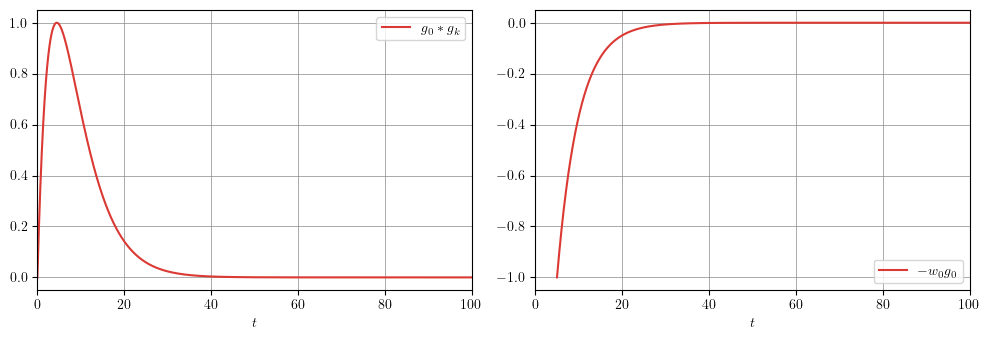

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].plot(times, input_spike_resp(times), c="C1", label=r"$g_0 * g_k$")
axes[1].plot(times, refractory_spike_resp(times), c="C1", label=r"$-w_0 g_0$")
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel(r"$t$")
axes[0].set_xlim(0, period)
axes[1].set_xlabel(r"$t$")
axes[1].set_xlim(0, period)
fig.tight_layout()

In [11]:
spike_train_generator = PeriodicSpikeTrainGenerator(firing_rate, abs_refractory_period, rel_refractory_period, )

In [12]:
input_spike_trains = spike_train_generator.rand(period, num_inputs)
target_spike_train = spike_train_generator.rand(period)

Multi-channel periodic spike train sampling:   0%|          | 0/250 [00:00<?, ?it/s]

In [13]:
num_spikes = np.array([spike_train.num_spikes for spike_train in input_spike_trains.spike_trains])

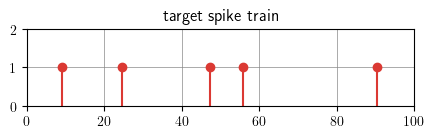

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 1))
ax.stem(target_spike_train.firing_times, np.ones_like(target_spike_train.firing_times), basefmt=" ", markerfmt="C1o", linefmt="C1-")
ax.set_xlim(0, period)
ax.set_ylim(0, 2)
ax.set_title("target spike train")
plt.show()

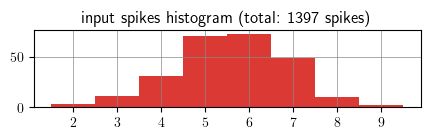

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 1))
ax.hist(num_spikes, bins=np.arange(np.min(num_spikes)-0.5, np.max(num_spikes)+1.5), color="C1")
ax.set_title(f"input spikes histogram (total: {np.sum(num_spikes)} spikes)")
plt.show()

# Computing Weights

In [16]:
def compute_spike_train(weights):
    spike_train = target_spike_train.copy()
    
    fun = lambda t_: potential(t_, delays, weights, input_spike_trains) - threshold(t_, spike_train, modulo=False)

    ta = spike_train.firing_times[-1] + abs_refractory_period
    while(ta < 2*period):
        tb = ta + 1
        if fun(ta) * fun(tb) <= 0:
            t = brentq(fun, ta, tb)
            spike_train.append(t)
            ta += abs_refractory_period
        else:
            ta += 1

    return spike_train

In [17]:
def compute_template(max_level, firing_region, min_slope, time_step):
    yf, ys, yl = [], [], []
    zf, zs, zl = [], [], []
    
    # equality at firing times
    for t in target_spike_train.firing_times:
        yf.append(
            np.array(
                [np.sum(input_spike_resp(
                    (t - delays[k] - input_spike_trains.spike_trains[k].firing_times) % period
                ))
                for k in range(num_inputs)] 
            )
        )
        zf.append(firing_threshold - np.sum(refractory_spike_resp((t - target_spike_train.firing_times) % period)))
        
    # smaller than the firing threshold everywhere (except during the absolute refractory period)
    for t in cyclic_after(target_spike_train.firing_times, period, abs_refractory_period, time_step, True):
        yl.append(
                np.array(
                    [np.sum(input_spike_resp(
                        (t - delays[k] - input_spike_trains.spike_trains[k].firing_times) % period
                    ))
                    for k in range(num_inputs)] 
                )
            )
        zl.append(firing_threshold - np.sum(refractory_spike_resp((t - target_spike_train.firing_times) % period)))
        
    # smaller than the maximum level not close to firing (except during the absolute refractory period)
    for t in cyclic_neighborhood(target_spike_train.firing_times, period, firing_region, abs_refractory_period, time_step, True):
        yl.append(
                np.array(
                    [np.sum(input_spike_resp(
                        (t - delays[k] - input_spike_trains.spike_trains[k].firing_times) % period
                    ))
                    for k in range(num_inputs)] 
                )
            )
        zl.append(max_level - np.sum(refractory_spike_resp((t - target_spike_train.firing_times) % period)))
        
    # slope larger than the minimum slope close to firing
    for t in cyclic_neighborhood(target_spike_train.firing_times, period, firing_region, firing_region, time_step):
        ys.append(
            np.array(
                [np.sum(input_spike_resp_deriv(
                    (t - delays[k] - input_spike_trains.spike_trains[k].firing_times) % period
                ))
                for k in range(num_inputs)] 
            )
        )
        zs.append(min_slope)
        
    return np.vstack(yf), np.array(zf), np.vstack(yl), np.array(zl), np.vstack(ys), np.array(zs) 

In [18]:
yf, zf, yl, zl, ys, zs = compute_template(firing_threshold - 0.5, 1.0, 0.5, 0.2)

## Bounded Weights

In [19]:
beta_w = 1.0
beta_f, beta_l, beta_s = 2.0, 0.8, 0.8 

In [20]:
kappa_w = lambda w_: box_cost(w_, wmin, wmax, beta=beta_w)
kappa_zf = lambda z_, zf_: laplace_cost(z_, zf_, beta=beta_f)
kappa_zl = lambda z_, zl_: half_space_cost(z_, xmax=zl_, beta=beta_l)
kappa_zs = lambda z_, zs_: half_space_cost(z_, xmin=zs_, beta=beta_s)

nuv_w = lambda mw_, Vw_: box_prior(mw, wmin, wmax, beta=beta_w)
nuv_zf = lambda mz_, zf_: laplace_prior(mz_, zf_, beta=beta_f)
nuv_zl = lambda mz_, zl_: half_space_prior(mz_, xmax=zl_, beta=beta_l) 
nuv_zs = lambda mz_, zs_: half_space_prior(mz_, xmin=zs_, beta=beta_s)

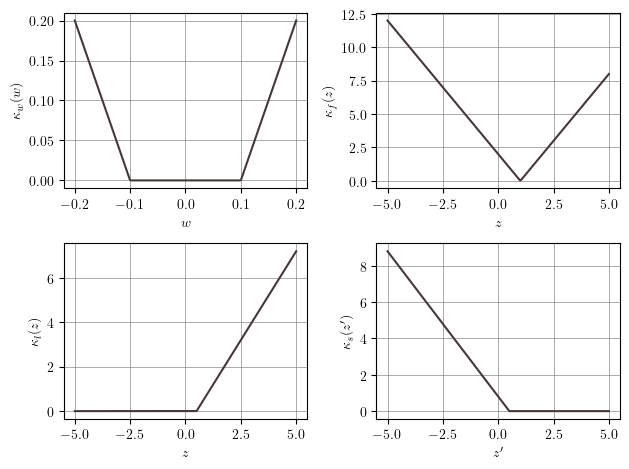

In [21]:
w, z = np.linspace(-0.2, 0.2, 250), np.linspace(-5.0, 5.0, 250)

fig, axes = plt.subplots(ncols=2, nrows=2)

axes[0,0].plot(w, kappa_w(w), c="C0")
axes[0,0].set_xlabel(r"$w$")
axes[0,0].set_ylabel(r"$\kappa_w(w)$")

axes[0,1].plot(z, kappa_zf(z, firing_threshold), c="C0")
axes[0,1].set_xlabel(r"$z$")
axes[0,1].set_ylabel(r"$\kappa_f(z)$")

axes[1,0].plot(z, kappa_zl(z, firing_threshold - 0.5), c="C0")
axes[1,0].set_xlabel(r"$z$")
axes[1,0].set_ylabel(r"$\kappa_l(z)$")

axes[1,1].plot(z, kappa_zs(z, 0.5), c="C0")
axes[1,1].set_xlabel(r"$z'$")
axes[1,1].set_ylabel(r"$\kappa_s(z')$")

fig.tight_layout()

In [22]:
mw_hist, Vw_hist = [], []
mw_cost_hist, mzf_cost_hist, mzl_cost_hist, mzs_cost_hist = [], [], [], []

mw, Vw = rng.uniform(wmin, wmax, num_inputs), np.ones(num_inputs)
mzf, mzl, mzs = yf@mw, yl@mw, ys@mw

mw_hist.append(mw)
Vw_hist.append(Vw)
prev_mw, prev_Vw = np.copy(mw), np.copy(Vw)

for i in trange(2000, desc="Optimization"):
    # compute nuv priors based on posterior means only (no variances)
    mfw, Vfw = nuv_w(mw, Vw)
    mfzf, Vfzf = nuv_zf(mzf, zf)
    mfzl, Vfzl = nuv_zl(mzl, zl)
    mfzs, Vfzs = nuv_zs(mzs, zs)

    # compute weights posterior means by forward message passing
    mw = np.copy(mfw)
    Vw = np.diag(Vfw)
    for yfn, mfzfn, Vfzfn in zip(yf, mfzf, Vfzf):
        mw, Vw = observation_block_forward(yfn, mw, Vw, mfzfn, Vfzfn)
    for yln, mfzln, Vfzln in zip(yl, mfzl, Vfzl):
        mw, Vw = observation_block_forward(yln, mw, Vw, mfzln, Vfzln)
    for ysn, mfzsn, Vfzsn in zip(ys, mfzs, Vfzs):
        mw, Vw = observation_block_forward(ysn, mw, Vw, mfzsn, Vfzsn)
    Vw = np.diag(Vw)
    
    # compute potential posterior means
    mzf, mzl, mzs = yf@mw, yl@mw, ys@mw
    
    # save in the history
    mw_hist.append(mw)
    Vw_hist.append(Vw)
    mw_cost_hist.append(np.sum(kappa_w(mw)))
    mzf_cost_hist.append(np.sum(kappa_zf(mzf, zf)))
    mzl_cost_hist.append(np.sum(kappa_zl(mzl, zl)))
    mzs_cost_hist.append(np.sum(kappa_zs(mzs, zs)))
    
    if np.allclose(mw, prev_mw) and np.allclose(Vw, prev_Vw):
        break
        
    prev_mw, prev_Vw = np.copy(mw), np.copy(Vw)

Optimization:   0%|          | 0/2000 [00:00<?, ?it/s]

In [23]:
mw_hist, Vw_hist = np.array(mw_hist), np.array(Vw_hist)
mw_cost_hist = np.array(mw_cost_hist)
mzf_cost_hist, mzl_cost_hist, mzs_cost_hist = np.array(mzf_cost_hist), np.array(mzl_cost_hist), np.array(mzs_cost_hist)

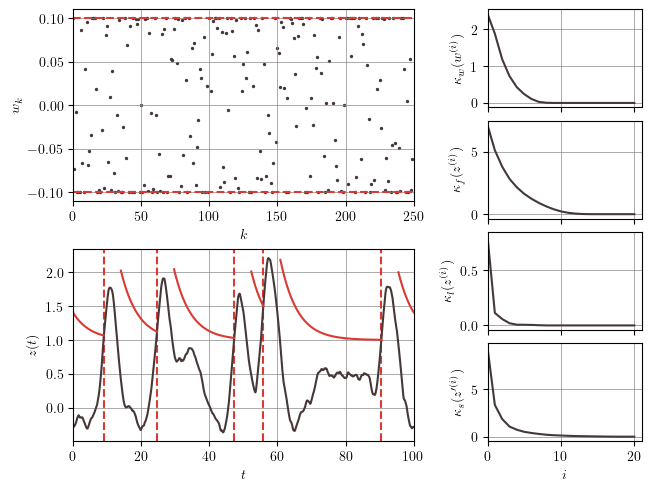

In [24]:
fig = plt.figure(layout="constrained")
subplots = fig.subfigures(nrows=1, ncols=2, width_ratios=[2, 1])

axes_template = subplots[0].subplots(nrows=2, ncols=1)

_ = axes_template[0].scatter(np.arange(num_inputs), mw_hist[-1], s=2, c="C0", label=r"$w$")
_ = axes_template[0].set_xlim(0, num_inputs)
_ = axes_template[0].set_xlabel(r"$k$")
_ = axes_template[0].set_ylabel(r"$w_k$")
_ = axes_template[0].axhline(wmin, linestyle="--", c="C1")
_ = axes_template[0].axhline(wmax, linestyle="--", c="C1")

for s in target_spike_train.firing_times:
    _ = axes_template[1].axvline(s, linestyle="--", c="C1")
_ = axes_template[1].plot(times, potential(times, delays, mw_hist[-1], input_spike_trains), c="C0", label=r"$w$")
_ = axes_template[1].plot(times, threshold(times, target_spike_train), c="C1")
_ = axes_template[1].set_xlim(0, period)
_ = axes_template[1].set_xlabel(r"$t$")
_ = axes_template[1].set_ylabel(r"$z(t)$")

axes_cost = subplots[1].subplots(nrows=4, ncols=1, sharex=True)

_ = axes_cost[0].plot(np.arange(mw_cost_hist.size), mw_cost_hist, c="C0", label=r"$w$")
_ = axes_cost[0].set_ylabel(r"$\kappa_w(w^{(i)})$")


_ = axes_cost[1].plot(np.arange(mzf_cost_hist.size), mzf_cost_hist, c="C0", label=r"$w$")
_ = axes_cost[1].set_ylabel(r"$\kappa_f(z^{(i)})$")

_ = axes_cost[2].plot(np.arange(mzl_cost_hist.size), mzl_cost_hist, c="C0", label=r"$w$")
_ = axes_cost[2].set_ylabel(r"$\kappa_l(z^{(i)})$")

_ = axes_cost[3].plot(np.arange(mzs_cost_hist.size), mzs_cost_hist, c="C0", label=r"$w$")
_ = axes_cost[3].set_xlabel(r"$i$")
_ = axes_cost[3].set_ylabel(r"$\kappa_s(z'^{(i)})$");
_ = axes_cost[3].set_xlim(0, None);

In [25]:
spike_train = compute_spike_train(mw_hist[-1])
spike_train_ = SpikeTrain(spike_train.firing_times[spike_train.firing_times > period])
corr, lag = single_channel_correlation(target_spike_train, spike_train_, eps=1e-3)

print(f"spike train similarity: {corr:.3f} (with a lag of {lag:.3f})" )
print(f"sparsity: {1 - np.count_nonzero(mw_hist[-1])/num_inputs:.3f}")
print(f"energy: {np.sum(np.square(mw_hist[-1]))/num_inputs:.3f}")

spike train similarity: 1.000 (with a lag of -0.000)
sparsity: 0.000
energy: 0.007


## Bounded Weights with L2 Regularization

In [26]:
beta_wbox, beta_wgauss = 5.0, 2.0 # beta_wgauss = 1 / 2*s2
beta_f, beta_l, beta_s = 2.0, 0.8, 0.8 

In [27]:
kappa_w = lambda w_: box_cost(w_, wmin, wmax, beta=beta_wbox) + np.square(w_) * beta_wgauss
kappa_zf = lambda z_, zf_: laplace_cost(z_, zf_, beta=beta_f)
kappa_zl = lambda z_, zl_: half_space_cost(z_, xmax=zl_, beta=beta_l)
kappa_zs = lambda z_, zs_: half_space_cost(z_, xmin=zs_, beta=beta_s)

nuv_w = lambda mw_, Vw_: equality_block(*box_prior(mw_, wmin, wmax, beta=beta_wbox), 0, 1/(2*beta_wgauss))
nuv_zf = lambda mz_, zf_: laplace_prior(mz_, zf_, beta=beta_f)
nuv_zl = lambda mz_, zl_: half_space_prior(mz_, xmax=zl_, beta=beta_l) 
nuv_zs = lambda mz_, zs_: half_space_prior(mz_, xmin=zs_, beta=beta_s)

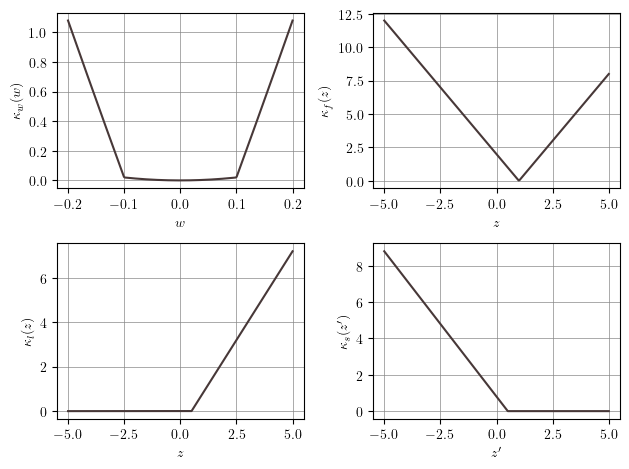

In [28]:
w, z, dz = np.linspace(-0.2, 0.2, 250), np.linspace(-5.0, 5.0, 250), np.linspace(-5.0, 5.0, 250)

fig, axes = plt.subplots(ncols=2, nrows=2)

axes[0,0].plot(w, kappa_w(w), c="C0")
axes[0,0].set_xlabel(r"$w$")
axes[0,0].set_ylabel(r"$\kappa_w(w)$")

axes[0,1].plot(z, laplace_cost(z, firing_threshold, beta=beta_f), c="C0")
axes[0,1].set_xlabel(r"$z$")
axes[0,1].set_ylabel(r"$\kappa_f(z)$")

axes[1,0].plot(z, half_space_cost(z, xmax=firing_threshold - 0.5, beta=beta_l), c="C0")
axes[1,0].set_xlabel(r"$z$")
axes[1,0].set_ylabel(r"$\kappa_l(z)$")

axes[1,1].plot(z, half_space_cost(z, xmin=0.5, beta=beta_s), c="C0")
axes[1,1].set_xlabel(r"$z'$")
axes[1,1].set_ylabel(r"$\kappa_s(z')$")

fig.tight_layout()

In [29]:
mw_hist, Vw_hist = [], []
mw_cost_hist, mzf_cost_hist, mzl_cost_hist, mzs_cost_hist = [], [], [], []

mw, Vw = rng.uniform(wmin, wmax, num_inputs), np.ones(num_inputs)
mzf, mzl, mzs = yf@mw, yl@mw, ys@mw

mw_hist.append(mw)
Vw_hist.append(Vw)
prev_mw, prev_Vw = np.copy(mw), np.copy(Vw)

for i in trange(2000, desc="Optimization"):
    # compute nuv priors based on posterior means only (no variances)
    mfw, Vfw = nuv_w(mw, Vw)
    mfzf, Vfzf = nuv_zf(mzf, zf)
    mfzl, Vfzl = nuv_zl(mzl, zl)
    mfzs, Vfzs = nuv_zs(mzs, zs)

    # compute weights posterior means by forward message passing
    mw = np.copy(mfw)
    Vw = np.diag(Vfw)
    for yfn, mfzfn, Vfzfn in zip(yf, mfzf, Vfzf):
        mw, Vw = observation_block_forward(yfn, mw, Vw, mfzfn, Vfzfn)
    for yln, mfzln, Vfzln in zip(yl, mfzl, Vfzl):
        mw, Vw = observation_block_forward(yln, mw, Vw, mfzln, Vfzln)
    for ysn, mfzsn, Vfzsn in zip(ys, mfzs, Vfzs):
        mw, Vw = observation_block_forward(ysn, mw, Vw, mfzsn, Vfzsn)
    Vw = np.diag(Vw)
    
    # compute potential posterior means
    mzf, mzl, mzs = yf@mw, yl@mw, ys@mw
    
    # save in the history
    mw_hist.append(mw)
    Vw_hist.append(Vw)
    mw_cost_hist.append(np.sum(kappa_w(mw)))
    mzf_cost_hist.append(np.sum(kappa_zf(mzf, zf)))
    mzl_cost_hist.append(np.sum(kappa_zl(mzl, zl)))
    mzs_cost_hist.append(np.sum(kappa_zs(mzs, zs)))
    
    if np.allclose(mw, prev_mw) and np.allclose(Vw, prev_Vw):
        break
        
    prev_mw, prev_Vw = np.copy(mw), np.copy(Vw)

Optimization:   0%|          | 0/2000 [00:00<?, ?it/s]

In [30]:
mw_hist, Vw_hist = np.array(mw_hist), np.array(Vw_hist)
mw_cost_hist = np.array(mw_cost_hist)
mzf_cost_hist, mzl_cost_hist, mzs_cost_hist = np.array(mzf_cost_hist), np.array(mzl_cost_hist), np.array(mzs_cost_hist)

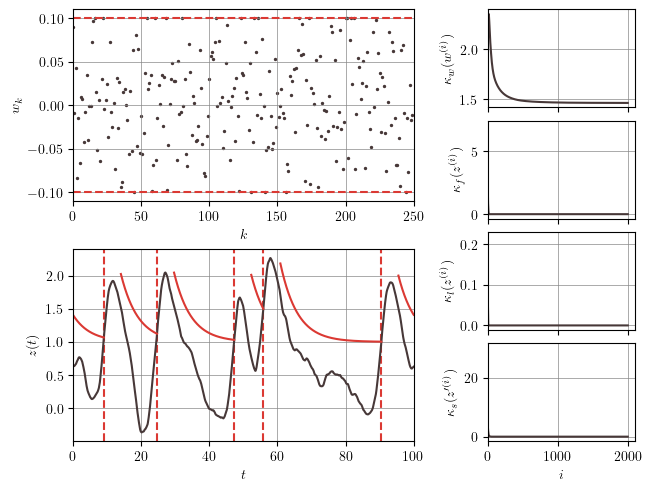

In [31]:
fig = plt.figure(layout="constrained")
subplots = fig.subfigures(nrows=1, ncols=2, width_ratios=[2, 1])

axes_template = subplots[0].subplots(nrows=2, ncols=1)

_ = axes_template[0].scatter(np.arange(num_inputs), mw_hist[-1], s=2, c="C0", label=r"$w$")
_ = axes_template[0].set_xlim(0, num_inputs)
_ = axes_template[0].set_xlabel(r"$k$")
_ = axes_template[0].set_ylabel(r"$w_k$")
_ = axes_template[0].axhline(wmin, linestyle="--", c="C1")
_ = axes_template[0].axhline(wmax, linestyle="--", c="C1")

for s in target_spike_train.firing_times:
    _ = axes_template[1].axvline(s, linestyle="--", c="C1")
_ = axes_template[1].plot(times, potential(times, delays, mw_hist[-1], input_spike_trains), c="C0", label=r"$w$")
_ = axes_template[1].plot(times, threshold(times, target_spike_train), c="C1")
_ = axes_template[1].set_xlim(0, period)
_ = axes_template[1].set_xlabel(r"$t$")
_ = axes_template[1].set_ylabel(r"$z(t)$")

axes_cost = subplots[1].subplots(nrows=4, ncols=1, sharex=True)

_ = axes_cost[0].plot(np.arange(mw_cost_hist.size), mw_cost_hist, c="C0", label=r"$w$")
_ = axes_cost[0].set_ylabel(r"$\kappa_w(w^{(i)})$")


_ = axes_cost[1].plot(np.arange(mzf_cost_hist.size), mzf_cost_hist, c="C0", label=r"$w$")
_ = axes_cost[1].set_ylabel(r"$\kappa_f(z^{(i)})$")

_ = axes_cost[2].plot(np.arange(mzl_cost_hist.size), mzl_cost_hist, c="C0", label=r"$w$")
_ = axes_cost[2].set_ylabel(r"$\kappa_l(z^{(i)})$")

_ = axes_cost[3].plot(np.arange(mzs_cost_hist.size), mzs_cost_hist, c="C0", label=r"$w$")
_ = axes_cost[3].set_xlabel(r"$i$")
_ = axes_cost[3].set_ylabel(r"$\kappa_s(z'^{(i)})$");
_ = axes_cost[3].set_xlim(0, None);

In [32]:
spike_train = compute_spike_train(mw_hist[-1])
spike_train_ = SpikeTrain(spike_train.firing_times[spike_train.firing_times > period])
corr, lag = single_channel_correlation(target_spike_train, spike_train_, eps=1e-3)

print(f"spike train similarity: {corr:.3f} (with a lag of {lag:.3f})" )
print(f"sparsity: {1 - np.count_nonzero(mw_hist[-1])/num_inputs:.3f}")
print(f"energy: {np.sum(np.square(mw_hist[-1]))/num_inputs:.3f}")

spike train similarity: 1.000 (with a lag of -0.000)
sparsity: 0.000
energy: 0.003


## Bounded Weights with L1 Regularization

In [33]:
beta_wbox, beta_wlaplace = 10.0, 1.0
beta_f, beta_l, beta_s = 2.0, 1.0, 1.0 

In [34]:
kappa_w = lambda w_: box_cost(w_, wmin, wmax, beta=beta_wbox) + laplace_cost(w_, 0, beta=beta_wlaplace)
kappa_zf = lambda z_, zf_: laplace_cost(z_, zf_, beta=beta_f)
kappa_zl = lambda z_, zl_: half_space_cost(z_, xmax=zl_, beta=beta_l)
kappa_zs = lambda z_, zs_: half_space_cost(z_, xmin=zs_, beta=beta_s)

nuv_w = lambda mw_, Vw_: equality_block(
    *box_prior(mw_, wmin, wmax, beta=beta_wbox), 
    *laplace_prior(mw_, x=0, beta=beta_wlaplace)
)
nuv_zf = lambda mz_, zf_: laplace_prior(mz_, zf_, beta=beta_f)
nuv_zl = lambda mz_, zl_: half_space_prior(mz_, xmax=zl_, beta=beta_l) 
nuv_zs = lambda mz_, zs_: half_space_prior(mz_, xmin=zs_, beta=beta_s)

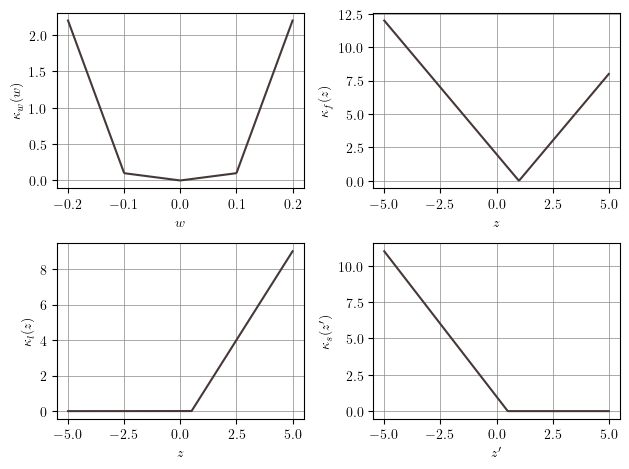

In [35]:
w, z, dz = np.linspace(-0.2, 0.2, 250), np.linspace(-5.0, 5.0, 250), np.linspace(-5.0, 5.0, 250)

fig, axes = plt.subplots(ncols=2, nrows=2)

axes[0,0].plot(w, kappa_w(w), c="C0")
axes[0,0].set_xlabel(r"$w$")
axes[0,0].set_ylabel(r"$\kappa_w(w)$")

axes[0,1].plot(z, laplace_cost(z, firing_threshold, beta=beta_f), c="C0")
axes[0,1].set_xlabel(r"$z$")
axes[0,1].set_ylabel(r"$\kappa_f(z)$")

axes[1,0].plot(z, half_space_cost(z, xmax=firing_threshold - 0.5, beta=beta_l), c="C0")
axes[1,0].set_xlabel(r"$z$")
axes[1,0].set_ylabel(r"$\kappa_l(z)$")

axes[1,1].plot(z, half_space_cost(z, xmin=0.5, beta=beta_s), c="C0")
axes[1,1].set_xlabel(r"$z'$")
axes[1,1].set_ylabel(r"$\kappa_s(z')$")

fig.tight_layout()

In [36]:
mw_hist, Vw_hist = [], []
mw_cost_hist, mzf_cost_hist, mzl_cost_hist, mzs_cost_hist = [], [], [], []

mw, Vw = rng.uniform(wmin, wmax, num_inputs), np.ones(num_inputs)
mzf, mzl, mzs = yf@mw, yl@mw, ys@mw

mw_hist.append(mw)
Vw_hist.append(Vw)
prev_mw, prev_Vw = np.copy(mw), np.copy(Vw)

for i in trange(2000, desc="Optimization"):
    # compute nuv priors based on posterior means only (no variances)
    mfw, Vfw = nuv_w(mw, Vw)
    mfzf, Vfzf = nuv_zf(mzf, zf)
    mfzl, Vfzl = nuv_zl(mzl, zl)
    mfzs, Vfzs = nuv_zs(mzs, zs)

    # compute weights posterior means by forward message passing
    mw = np.copy(mfw)
    Vw = np.diag(Vfw)
    for yfn, mfzfn, Vfzfn in zip(yf, mfzf, Vfzf):
        mw, Vw = observation_block_forward(yfn, mw, Vw, mfzfn, Vfzfn)
    for yln, mfzln, Vfzln in zip(yl, mfzl, Vfzl):
        mw, Vw = observation_block_forward(yln, mw, Vw, mfzln, Vfzln)
    for ysn, mfzsn, Vfzsn in zip(ys, mfzs, Vfzs):
        mw, Vw = observation_block_forward(ysn, mw, Vw, mfzsn, Vfzsn)
    Vw = np.diag(Vw)
    
    # compute potential posterior means
    mzf, mzl, mzs = yf@mw, yl@mw, ys@mw
    
    # save in the history
    mw_hist.append(mw)
    Vw_hist.append(Vw)
    mw_cost_hist.append(np.sum(kappa_w(mw)))
    mzf_cost_hist.append(np.sum(kappa_zf(mzf, zf)))
    mzl_cost_hist.append(np.sum(kappa_zl(mzl, zl)))
    mzs_cost_hist.append(np.sum(kappa_zs(mzs, zs)))
    
    if np.allclose(mw, prev_mw) and np.allclose(Vw, prev_Vw):
        break
        
    prev_mw, prev_Vw = np.copy(mw), np.copy(Vw)

Optimization:   0%|          | 0/2000 [00:00<?, ?it/s]

In [37]:
mw_hist, Vw_hist = np.array(mw_hist), np.array(Vw_hist)
mw_cost_hist = np.array(mw_cost_hist)
mzf_cost_hist, mzl_cost_hist, mzs_cost_hist = np.array(mzf_cost_hist), np.array(mzl_cost_hist), np.array(mzs_cost_hist)

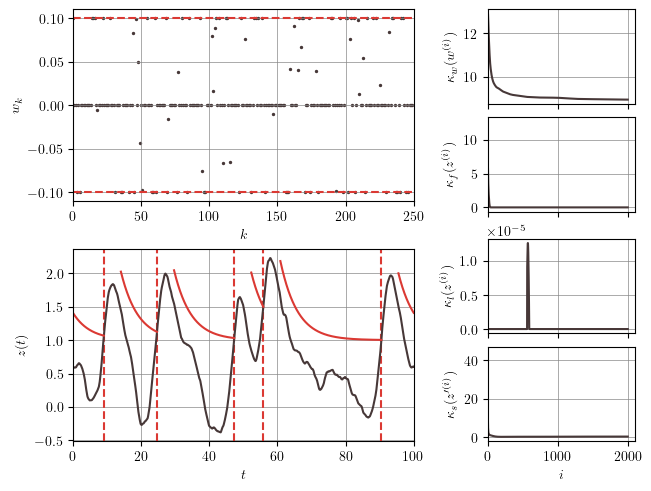

In [38]:
fig = plt.figure(layout="constrained")
subplots = fig.subfigures(nrows=1, ncols=2, width_ratios=[2, 1])

axes_template = subplots[0].subplots(nrows=2, ncols=1)

_ = axes_template[0].scatter(np.arange(num_inputs), mw_hist[-1], s=2, c="C0", label=r"$w$")
_ = axes_template[0].set_xlim(0, num_inputs)
_ = axes_template[0].set_xlabel(r"$k$")
_ = axes_template[0].set_ylabel(r"$w_k$")
_ = axes_template[0].axhline(wmin, linestyle="--", c="C1")
_ = axes_template[0].axhline(wmax, linestyle="--", c="C1")

for s in target_spike_train.firing_times:
    _ = axes_template[1].axvline(s, linestyle="--", c="C1")
_ = axes_template[1].plot(times, potential(times, delays, mw_hist[-1], input_spike_trains), c="C0", label=r"$w$")
_ = axes_template[1].plot(times, threshold(times, target_spike_train), c="C1")
_ = axes_template[1].set_xlim(0, period)
_ = axes_template[1].set_xlabel(r"$t$")
_ = axes_template[1].set_ylabel(r"$z(t)$")

axes_cost = subplots[1].subplots(nrows=4, ncols=1, sharex=True)

_ = axes_cost[0].plot(np.arange(mw_cost_hist.size), mw_cost_hist, c="C0", label=r"$w$")
_ = axes_cost[0].set_ylabel(r"$\kappa_w(w^{(i)})$")


_ = axes_cost[1].plot(np.arange(mzf_cost_hist.size), mzf_cost_hist, c="C0", label=r"$w$")
_ = axes_cost[1].set_ylabel(r"$\kappa_f(z^{(i)})$")

_ = axes_cost[2].plot(np.arange(mzl_cost_hist.size), mzl_cost_hist, c="C0", label=r"$w$")
_ = axes_cost[2].set_ylabel(r"$\kappa_l(z^{(i)})$")

_ = axes_cost[3].plot(np.arange(mzs_cost_hist.size), mzs_cost_hist, c="C0", label=r"$w$")
_ = axes_cost[3].set_xlabel(r"$i$")
_ = axes_cost[3].set_ylabel(r"$\kappa_s(z'^{(i)})$");
_ = axes_cost[3].set_xlim(0, None);

In [39]:
spike_train = compute_spike_train(mw_hist[-1])
spike_train_ = SpikeTrain(spike_train.firing_times[spike_train.firing_times > period])
corr, lag = single_channel_correlation(target_spike_train, spike_train_, eps=1e-3)

print(f"spike train similarity: {corr:.3f} (with a lag of {lag:.3f})" )
print(f"sparsity: {1 - np.count_nonzero(mw_hist[-1])/num_inputs:.3f}")
print(f"energy: {np.sum(np.square(mw_hist[-1]))/num_inputs:.3f}")

spike train similarity: 1.000 (with a lag of -0.000)
sparsity: 0.392
energy: 0.003


## Binary Weights

In [40]:
beta_wbox, beta_wplain = 5.0, -1.0
beta_f, beta_l, beta_s = 10.0, 1.0, 1.0 

In [41]:
kappa_w = lambda w_: box_cost(w_, wmin, wmax, beta=beta_wbox) + plain_cost(w_, x=(wmin+wmax)/2, beta=beta_wplain) - plain_cost(wmin, x=(wmin+wmax)/2, beta=beta_wplain)  
kappa_zf = lambda z_, zf_: laplace_cost(z_, zf_, beta=beta_f)
kappa_zl = lambda z_, zl_: half_space_cost(z_, xmax=zl_, beta=beta_l)
kappa_zs = lambda z_, zs_: half_space_cost(z_, xmin=zs_, beta=beta_s)

nuv_w = lambda mw_, Vw_: equality_block(
    *box_prior(mw_, wmin, wmax, beta=beta_wbox), 
    *plain_prior(mw_, Vw_, x=(wmin+wmax)/2, beta=beta_wplain)
)
nuv_zf = lambda mz_, zf_: laplace_prior(mz_, zf_, beta=beta_f)
nuv_zl = lambda mz_, zl_: half_space_prior(mz_, xmax=zl_, beta=beta_l) 
nuv_zs = lambda mz_, zs_: half_space_prior(mz_, xmin=zs_, beta=beta_s)

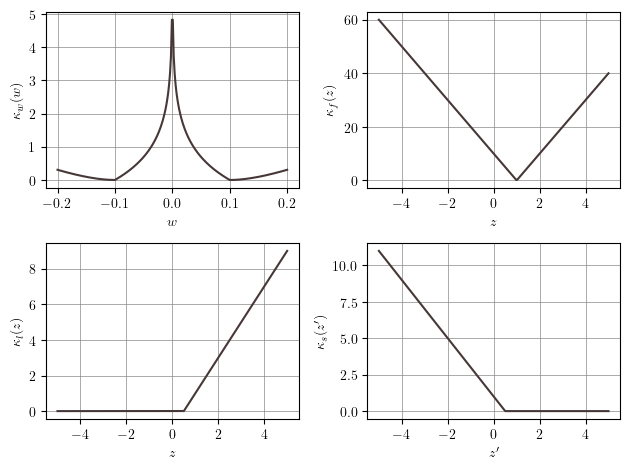

In [42]:
w, z, dz = np.linspace(-0.2, 0.2, 250), np.linspace(-5.0, 5.0, 250), np.linspace(-5.0, 5.0, 250)

fig, axes = plt.subplots(ncols=2, nrows=2)

axes[0,0].plot(w, kappa_w(w), c="C0")
axes[0,0].set_xlabel(r"$w$")
axes[0,0].set_ylabel(r"$\kappa_w(w)$")

axes[0,1].plot(z, laplace_cost(z, firing_threshold, beta=beta_f), c="C0")
axes[0,1].set_xlabel(r"$z$")
axes[0,1].set_ylabel(r"$\kappa_f(z)$")

axes[1,0].plot(z, half_space_cost(z, xmax=firing_threshold - 0.5, beta=beta_l), c="C0")
axes[1,0].set_xlabel(r"$z$")
axes[1,0].set_ylabel(r"$\kappa_l(z)$")

axes[1,1].plot(z, half_space_cost(z, xmin=0.5, beta=beta_s), c="C0")
axes[1,1].set_xlabel(r"$z'$")
axes[1,1].set_ylabel(r"$\kappa_s(z')$")

fig.tight_layout()

In [43]:
mw_hist, mwr_hist = [], []
mw_cost_hist, mwr_cost_hist = [], []
mzf_cost_hist, mzrf_cost_hist = [], []
mzl_cost_hist, mzrl_cost_hist = [], []
mzs_cost_hist, mzrs_cost_hist = [], []

mw, Vw = rng.uniform(wmin, wmax, num_inputs), np.ones(num_inputs)
mwr = wmin*(mw<0) + wmax*(mw>0)
mzf, mzl, mzs = yf@mw, yl@mw, ys@mw
mzrf, mzrl, mzrs = yf@mwr, yl@mwr, ys@mwr

mw_hist.append(mw)
mwr_hist.append(mwr)
mw_cost_hist.append(np.sum(kappa_w(mw)))
mwr_cost_hist.append(np.sum(kappa_w(mwr)))
mzf_cost_hist.append(np.sum(kappa_zf(mzf, zf)))
mzrf_cost_hist.append(np.sum(kappa_zf(mzrf, zf)))
mzl_cost_hist.append(np.sum(kappa_zl(mzl, zl)))
mzrl_cost_hist.append(np.sum(kappa_zl(mzrl, zl)))
mzs_cost_hist.append(np.sum(kappa_zs(mzs, zs)))
mzrs_cost_hist.append(np.sum(kappa_zs(mzrs, zs)))

prev_mw, prev_Vw = np.copy(mw), np.copy(Vw)

for i in trange(2000, desc="Optimization"):
    # compute nuv priors based on posterior means only (no variances)
    mfw, Vfw = nuv_w(mw, Vw)
    mfzf, Vfzf = nuv_zf(mzf, zf)
    mfzl, Vfzl = nuv_zl(mzl, zl)
    mfzs, Vfzs = nuv_zs(mzs, zs)

    # compute weights posterior means by forward message passing
    mw = np.copy(mfw)
    Vw = np.diag(Vfw)
    for yfn, mfzfn, Vfzfn in zip(yf, mfzf, Vfzf):
        mw, Vw = observation_block_forward(yfn, mw, Vw, mfzfn, Vfzfn)
    for yln, mfzln, Vfzln in zip(yl, mfzl, Vfzl):
        mw, Vw = observation_block_forward(yln, mw, Vw, mfzln, Vfzln)
    for ysn, mfzsn, Vfzsn in zip(ys, mfzs, Vfzs):
        mw, Vw = observation_block_forward(ysn, mw, Vw, mfzsn, Vfzsn)
    Vw = np.diag(Vw)
    
    # rounded weights
    mwr = wmin*(mw<0) + wmax*(mw>0)
    
    # compute potential posterior means
    mzf, mzl, mzs = yf@mw, yl@mw, ys@mw
    mzrf, mzrl, mzrs = yf@mwr, yl@mwr, ys@mwr
    
    # save in the history
    mw_hist.append(mw)
    mwr_hist.append(mwr)
    mw_cost_hist.append(np.sum(kappa_w(mw)))
    mwr_cost_hist.append(np.sum(kappa_w(mwr)))
    mzf_cost_hist.append(np.sum(kappa_zf(mzf, zf)))
    mzrf_cost_hist.append(np.sum(kappa_zf(mzrf, zf)))
    mzl_cost_hist.append(np.sum(kappa_zl(mzl, zl)))
    mzrl_cost_hist.append(np.sum(kappa_zl(mzrl, zl)))
    mzs_cost_hist.append(np.sum(kappa_zs(mzs, zs)))
    mzrs_cost_hist.append(np.sum(kappa_zs(mzrs, zs)))
    
    if np.allclose(mw, prev_mw) and np.allclose(Vw, prev_Vw):
        break
        
    prev_mw, prev_Vw = np.copy(mw), np.copy(Vw)

Optimization:   0%|          | 0/2000 [00:00<?, ?it/s]

/Users/haguettaz/Documents/RSNN/src/rsnn/optim/cost.py:80: RuntimeWarning: divide by zero encountered in log
  return beta * np.log(np.abs(mx - x))


In [44]:
mw_hist, mwr_hist = np.array(mw_hist), np.array(mwr_hist)
mw_cost_hist, mwr_cost_hist = np.array(mw_cost_hist), np.array(mwr_cost_hist)
mzf_cost_hist, mzrf_cost_hist = np.array(mzf_cost_hist), np.array(mzrf_cost_hist)
mzl_cost_hist, mzrl_cost_hist = np.array(mzl_cost_hist), np.array(mzrl_cost_hist) 
mzs_cost_hist, mzrs_cost_hist  = np.array(mzs_cost_hist), np.array(mzrs_cost_hist)

In [45]:
fig = plt.figure(layout="constrained")
subplots = fig.subfigures(nrows=1, ncols=2, width_ratios=[2, 1])

axes_template = subplots[0].subplots(nrows=2, ncols=1)

_ = axes_template[0].scatter(np.arange(num_inputs), mw_hist[-1], s=2, c="C0", label=r"$w$")
_ = axes_template[0].scatter(np.arange(num_inputs), mwr_hist[-1], s=2, c="C2", label=r"$\bar{w}$")
_ = axes_template[0].set_xlim(0, num_inputs)
_ = axes_template[0].set_xlabel(r"$k$")
_ = axes_template[0].set_ylabel(r"$w_k$")
_ = axes_template[0].axhline(wmin, linestyle="--", c="C1")
_ = axes_template[0].axhline(wmax, linestyle="--", c="C1")

for s in target_spike_train.firing_times:
    _ = axes_template[1].axvline(s, linestyle="--", c="C1")
_ = axes_template[1].plot(times, potential(times, delays, mw_hist[-1], input_spike_trains), c="C0", label=r"$w$")
_ = axes_template[1].plot(times, potential(times, delays, mwr_hist[-1], input_spike_trains), c="C2", label=r"$\bar{w}$")
_ = axes_template[1].plot(times, threshold(times, target_spike_train), c="C1")
_ = axes_template[1].set_xlim(0, period)
_ = axes_template[1].set_xlabel(r"$t$")
_ = axes_template[1].set_ylabel(r"$z(t)$")

axes_cost = subplots[1].subplots(nrows=4, ncols=1, sharex=True)

_ = axes_cost[0].plot(np.arange(mw_cost_hist.size), mw_cost_hist, c="C0", label=r"$w$")
_ = axes_cost[0].plot(np.arange(mwr_cost_hist.size), mwr_cost_hist, c="C2", label=r"$\bar{w}$")
_ = axes_cost[0].set_ylabel(r"$\kappa_w(w^{(i)})$")


_ = axes_cost[1].plot(np.arange(mzf_cost_hist.size), mzf_cost_hist, c="C0", label=r"$w$")
_ = axes_cost[1].plot(np.arange(mzrf_cost_hist.size), mzrf_cost_hist, c="C2", label=r"$\bar{w}$")
_ = axes_cost[1].set_ylabel(r"$\kappa_f(z^{(i)})$")

_ = axes_cost[2].plot(np.arange(mzl_cost_hist.size), mzl_cost_hist, c="C0", label=r"$w$")
_ = axes_cost[2].plot(np.arange(mzrl_cost_hist.size), mzrl_cost_hist, c="C2", label=r"$\bar{w}$")
_ = axes_cost[2].set_ylabel(r"$\kappa_l(z^{(i)})$")

_ = axes_cost[3].plot(np.arange(mzs_cost_hist.size), mzs_cost_hist, c="C0", label=r"$w$")
_ = axes_cost[3].plot(np.arange(mzrs_cost_hist.size), mzrs_cost_hist, c="C2", label=r"$\bar{w}$")
_ = axes_cost[3].set_xlabel(r"$i$")
_ = axes_cost[3].set_ylabel(r"$\kappa_s(z'^{(i)})$");
_ = axes_cost[3].set_xlim(0, None);

In [46]:
spike_train = compute_spike_train(mw_hist[-1])
spike_train_ = SpikeTrain(spike_train.firing_times[spike_train.firing_times > period])
corr, lag = single_channel_correlation(target_spike_train, spike_train_, eps=1e-3)

print(f"spike train similarity: {corr:.3f} (with a lag of {lag:.3f})" )
print(f"sparsity: {1 - np.count_nonzero(mw_hist[-1])/num_inputs:.3f}")
print(f"energy: {np.sum(np.square(mw_hist[-1]))/num_inputs:.3f}")